# Electric Vehicle

## Úvod

Táto práca je venovaná predmetu Objavovanie znalostí ako projekt z deskriptívnej štatistiky. V našom projekte sme sa rozhodli pracovať s dátami o elektrických autách. Rozhodli sme sa tak preto, že otázka elektrických áut je čoraz viac aktuálna. Stále sa vo svete rieši cena a dojazd elektrických aut. Pracujeme s rôznymi atribútmi a zisťujeme, aké atribúty na sebe závisia, od čoho závisí cena elektrického auta a podobne.

Cieľom projektu bolo potvrdiť, alebo vyvrátiť hypotézy, ktoré sme si stanovili. Po analýze a úprave datasetu sme vypracovali predikčné modely a na základe nich sme vyhodnotili závery pre jednotlivé hypotézy.

Projekt je rozdelený do dvoch častí: praktická časť a teoretická časť. Tento dokument predstavuje praktickú časť.

Dataset: https://www.kaggle.com/datasets/geoffnel/evs-one-electric-vehicle-dataset (ElectricCarData_Clean.csv)

## Analýza dát

In [814]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import glob
import math 
import scipy as sc

from pandas import read_csv
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, accuracy_score, mean_squared_error, silhouette_score, confusion_matrix
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, normalize
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

from collections import Counter
from yellowbrick.cluster import KElbowVisualizer

Načítanie datasetu

In [815]:
# original_data = pd.read_csv("ElectricCarData_Clean.csv")
data = pd.read_csv("ElectricCarData_Clean.csv")

### Funkcie

Úprava stĺpcov a nahradenie invalidnej hodnoty

In [816]:
def EditColumns(data):
    data = data.drop(['PlugType'], axis = 1)

    data['FastCharge_KmH'] = data['FastCharge_KmH'].astype(str).str.replace('-','0')
    data['FastCharge_KmH'] = data['FastCharge_KmH'].astype(float)

    data.columns = data.columns.str.replace('AccelSec', 'Acceleration 0-100 (s)')
    data.columns = data.columns.str.replace('TopSpeed_KmH', 'TopSpeed (km/h)')
    data.columns = data.columns.str.replace('Range_Km', 'Range (km)')
    data.columns = data.columns.str.replace('Efficiency_WhKm', 'Efficiency (Wh/km)')
    data.columns = data.columns.str.replace('FastCharge_KmH', 'FastCharge (km/h)')
    return data

Identifikácia outlierov

In [817]:
def identify_outliers(data):
    lower = data.quantile(0.25) - 1.5 * stats.iqr(data)
    upper = data.quantile(0.75) + 1.5 * stats.iqr(data)
    
    return data[(data > upper) | (data < lower)]

Pretypovanie kategorických hodnôt do spojitých

In [818]:
def ReplaceStringValues(data):
    data['PowerTrain'] = data['PowerTrain'].astype(str).str.replace('AWD','3')
    data['PowerTrain'] = data['PowerTrain'].astype(str).str.replace('RWD','2')
    data['PowerTrain'] = data['PowerTrain'].astype(str).str.replace('FWD','1')
    data['PowerTrain'] = data['PowerTrain'].astype(int)

    data['RapidCharge'] = data['RapidCharge'].astype(str).str.replace('Yes','1')
    data['RapidCharge'] = data['RapidCharge'].astype(str).str.replace('No','0')
    data['RapidCharge'] = data['RapidCharge'].astype(int)

    data['BodyStyle'] = data['BodyStyle'].astype(str).str.replace('Hatchback','1')
    data['BodyStyle'] = data['BodyStyle'].astype(str).str.replace('Liftback','2')
    data['BodyStyle'] = data['BodyStyle'].astype(str).str.replace('Sedan','3')
    data['BodyStyle'] = data['BodyStyle'].astype(str).str.replace('Station','4')
    data['BodyStyle'] = data['BodyStyle'].astype(str).str.replace('Cabrio','5')
    data['BodyStyle'] = data['BodyStyle'].astype(str).str.replace('SUV','6')
    data['BodyStyle'] = data['BodyStyle'].astype(str).str.replace('MPV','7')
    data['BodyStyle'] = data['BodyStyle'].astype(str).str.replace('SPV','8')
    data['BodyStyle'] = data['BodyStyle'].astype(str).str.replace('Pickup','9')
    data['BodyStyle'] = data['BodyStyle'].astype(int)

    data['Segment'] = data['Segment'].astype(str).str.replace('A','1')
    data['Segment'] = data['Segment'].astype(str).str.replace('B','2')
    data['Segment'] = data['Segment'].astype(str).str.replace('C','3')
    data['Segment'] = data['Segment'].astype(str).str.replace('D','4')
    data['Segment'] = data['Segment'].astype(str).str.replace('E','5')
    data['Segment'] = data['Segment'].astype(str).str.replace('F','6')
    data['Segment'] = data['Segment'].astype(str).str.replace('N','7')
    data['Segment'] = data['Segment'].astype(str).str.replace('S','8')
    data['Segment'] = data['Segment'].astype(int)

    return data

In [819]:
data = EditColumns(data)

Ukážka datasetu

In [820]:
data.head()

,Brand,Model,Acceleration 0-100 (s),TopSpeed (km/h),Range (km),Efficiency (Wh/km),FastCharge (km/h),RapidCharge,PowerTrain,BodyStyle,Segment,Seats,PriceEuro
0,Tesla,Model 3 Long Range Dual Motor,4.6,233,450,161,940.0,Yes,AWD,Sedan,D,5,55480
1,Volkswagen,ID.3 Pure,10.0,160,270,167,250.0,Yes,RWD,Hatchback,C,5,30000
2,Polestar,2,4.7,210,400,181,620.0,Yes,AWD,Liftback,D,5,56440
3,BMW,iX3,6.8,180,360,206,560.0,Yes,RWD,SUV,D,5,68040
4,Honda,e,9.5,145,170,168,190.0,Yes,RWD,Hatchback,B,4,32997


Brand - značka vozidla

Model - konkrétny model danej značky vozidla

Acceleration 0-100 (s) - akcelerácia z 0 na 100

TopSpeed (km/h) - maximálna rýchlosť

Range (km) - dojazd na jedno nabitie

Efficiency (Wh/km) - spotreba Wh elektriny na prejdenie vzdialenosti 1 km

FastCharge (km/h) - počet kilometrov za dobu 1 hodiny rýchlonabíjania

RapidCharge - udáva, či vozidlo obsahuje funkciu rýchlonabíjania

PowerTrain - typ pohonu vozidla (AWD, RWD, FWD)

PlugType - typ elektrickej zásuvky

BodyStyle - typ karosérie (sedan, cabrio, SUV, hatchback… )

Segment - trieda vozidla (B - small, D - large, E - executive, J - SUV…)

Seats - počet sedadiel

PriceEuro - cena vozidla v eurách

Základné informácie o datasete

In [821]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Brand                   103 non-null    object 
 1   Model                   103 non-null    object 
 2   Acceleration 0-100 (s)  103 non-null    float64
 3   TopSpeed (km/h)         103 non-null    int64  
 4   Range (km)              103 non-null    int64  
 5   Efficiency (Wh/km)      103 non-null    int64  
 6   FastCharge (km/h)       103 non-null    float64
 7   RapidCharge             103 non-null    object 
 8   PowerTrain              103 non-null    object 
 9   BodyStyle               103 non-null    object 
 10  Segment                 103 non-null    object 
 11  Seats                   103 non-null    int64  
 12  PriceEuro               103 non-null    int64  
dtypes: float64(2), int64(5), object(6)
memory usage: 10.6+ KB


Dataset má 103 riadkov a 14 stĺpcov.

Dataset je zložený z atribútov:
- 6 spojitých
    - 1x float
    - 5x int
- 8 kategorických
    - 8x object
    
Nenachádzajú sa tu nulové hodnoty.

Deskriptívne štatistiky datasetu

In [822]:
data.describe()

,Acceleration 0-100 (s),TopSpeed (km/h),Range (km),Efficiency (Wh/km),FastCharge (km/h),Seats,PriceEuro
count,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000
mean,7.396117,179.194175,338.786408,189.165049,434.563107,4.883495,55811.563107
std,3.017430,43.573030,126.014444,29.566839,219.660061,0.795834,34134.665280
min,2.100000,123.000000,95.000000,104.000000,0.000000,2.000000,20129.000000
25%,5.100000,150.000000,250.000000,168.000000,260.000000,5.000000,34429.500000
50%,7.300000,160.000000,340.000000,180.000000,440.000000,5.000000,45000.000000
75%,9.000000,200.000000,400.000000,203.000000,555.000000,5.000000,65000.000000
max,22.400000,410.000000,970.000000,273.000000,940.000000,7.000000,215000.000000


In [823]:
data = ReplaceStringValues(data)

Heatmapa zobrazujúce hodnoty korelácie medzi jednotlivými atribútmi

<AxesSubplot:>

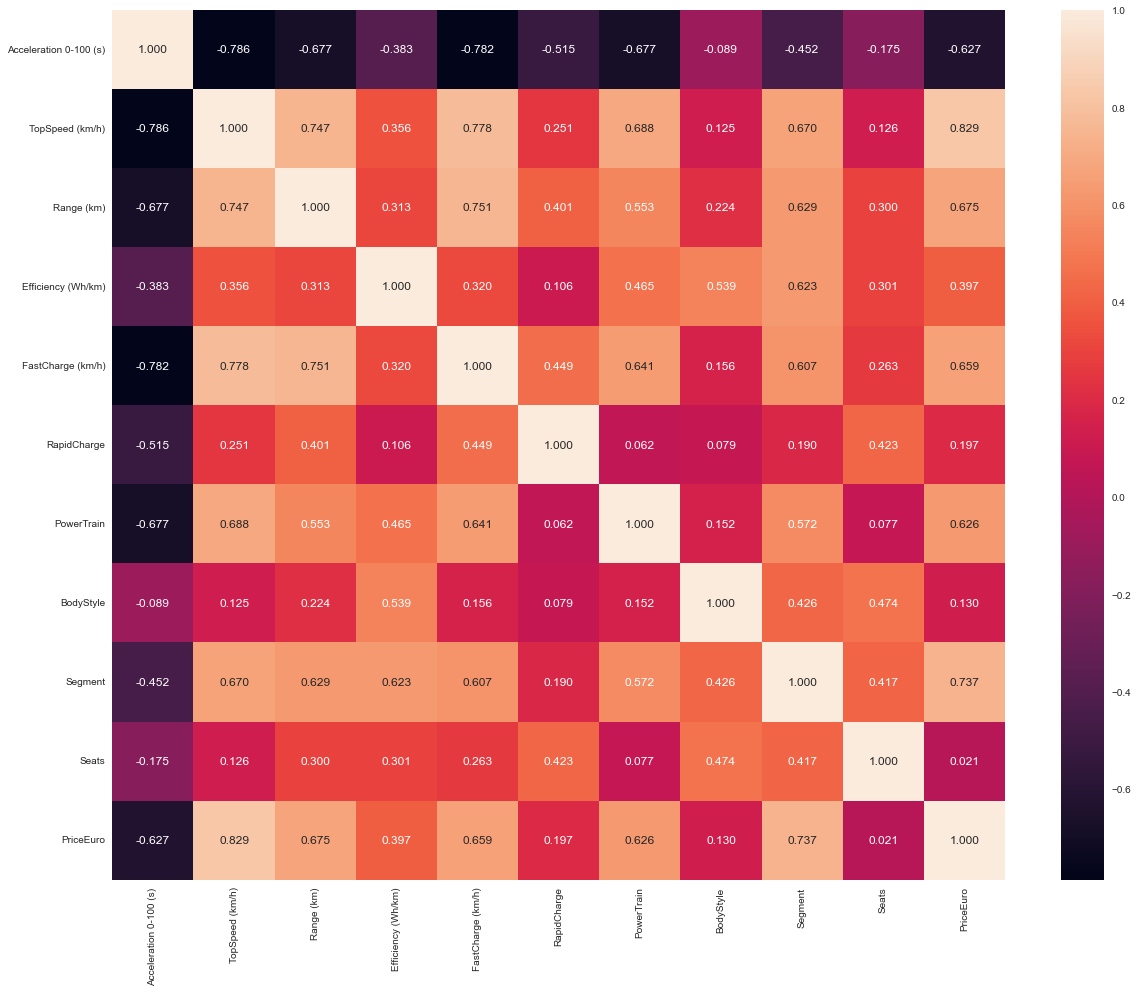

In [824]:
fig, ax = plt.subplots(figsize = (20, 16))
sns.heatmap(data.corr(), ax = ax, annot = True, fmt = ".3f")

Pairplot zobrazujúci rozmiestnenie hodnôt medzi 2 atribútmi

In [825]:
# sns.pairplot(data)

##  Dokazovanie hypotéz

###  Hypotéza č. 1

#### Na základe akcelerácie vozidla vieme predikovať s úspešnosťou minimálne 80%, či má vozidlo poháňanú jednu nápravu (FWD / RWD) alebo má poháňané obe nápravy (AWD).

Zobrazíme si boxplot, aby sme videli rozdiely v akcelerácií podľa typu poháňanej nápravy. Vidíme, že vozidlá, ktoré majú poháňané obe nápravy (AWD) majú výrazne nižšiu akceleráciu ako vozidlá s pohonom iba jednej nápravy.

C:\Users\Martin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='PowerTrain', ylabel='Acceleration 0-100 (s)'>

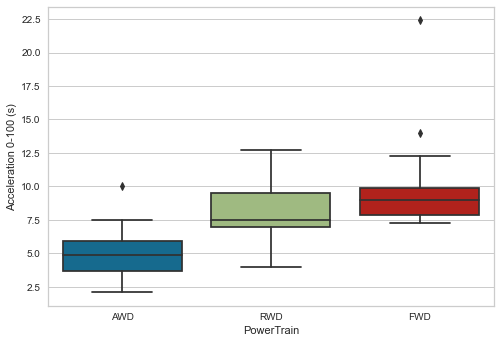

In [826]:
tempData = data.copy()
tempData['PowerTrain'].replace(to_replace=[1, 2, 3], value = ['FWD','RWD','AWD'], inplace = True)

sns.boxplot("PowerTrain", "Acceleration 0-100 (s)", data=tempData)

Vozidlá s pohonom iba jednej nápravy zoskupíme do jednej skupiny.

In [827]:
logRegData = data.copy()
logRegData['PowerTrain'].replace(to_replace=[2], value = [1], inplace = True)
x = logRegData[['Acceleration 0-100 (s)']]
y = logRegData[['PowerTrain']]

C:\Users\Martin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

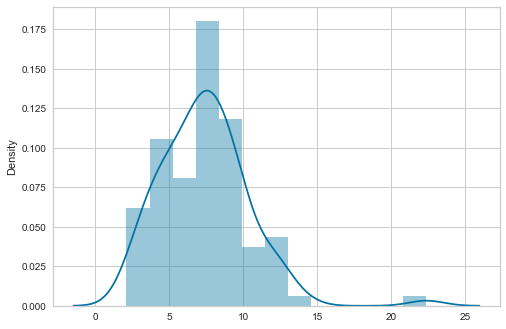

In [828]:
sns.distplot(logRegData[['Acceleration 0-100 (s)']])

Vidíme, že hodnoty nie sú z normálneho rozdelenia, tak odstránime outliere a vykreslíme si znovu graf.

C:\Users\Martin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Size of Dataset 102


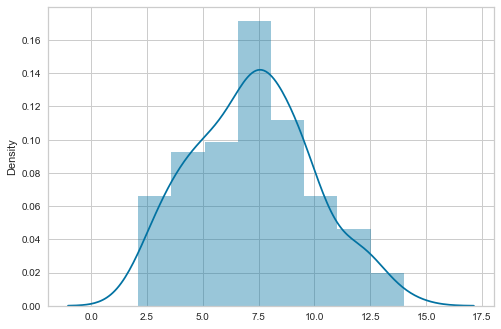

In [829]:
logRegData = logRegData.drop(identify_outliers(data['Acceleration 0-100 (s)']).index)
sns.distplot(logRegData[['Acceleration 0-100 (s)']])
print("Size of Dataset {}".format(len(logRegData)))

Po úprave má dataset 102 hodnôt. Teraz prejdeme na logistickú regresiu.

Rozdelíme si dáta na trénovaciu a testovaciu časť.

In [830]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 50)

Natrénovanie logistickej regresie

In [831]:
log = LogisticRegression()
log.fit(x_train, y_train.values.ravel())
prediction = log.predict(x_test)

print("Accuracy score on training set is {}".format(accuracy_score(logreg.predict(x_train),y_train)))
print("Accuracy score on test set is {}".format(accuracy_score(prediction,y_test)))

Accuracy score on training set is 0.9027777777777778
Accuracy score on test set is 0.9354838709677419


Vidíme, že presnosť na trénovacej aj testovacej vzorke je viac ako 90%

Vypočítame chybu RMSE

In [832]:
rmse = np.sqrt(mean_squared_error(y_test, prediction))
print("Error: ", rmse)

Error:  0.508000508000762


Zobrazenie confusion matice

In [834]:
confusion_matrix(y_test, prediction)

array([[16,  2],
       [ 0, 13]], dtype=int64)

In [835]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 25)

Na základe logistickej regresie sa zdá model relatívne dobrý.

### Hypotéza č. 2

#### Chceme zistiť či cena závisí viacej na:
#####     • kategórii vozidla vzhľadom na rýchlosť (TopSpeed a Acceleration), 
 
#####     • kategórii vozidla vzhľadom na schopnosti batérie - prejdenia vzdialenosti na 1 nabitie, kapacity nabitia batérie za hodinu (Range a FastCharge). 

Vozidlá si pomocou k means rozdelíme do 2 kategorii:
    - spojenim topspeed a acceleration
    - spojenim range a fastcharge

### Acceleration - TopSpeed

In [836]:
km_data = data

In [837]:
ACC_outliers = identify_outliers(km_data["Acceleration 0-100 (s)"])
km_data = km_data.drop(ACC_outliers.index)

TS_outliers = identify_outliers(km_data["TopSpeed (km/h)"])
km_data = km_data.drop(TS_outliers.index)

In [838]:
x=km_data[["Acceleration 0-100 (s)", "TopSpeed (km/h)","FastCharge (km/h)", "Range (km)"]]
y=km_data['PriceEuro']
x= sm.add_constant(x)
results = sm.OLS(y,x)
model=results.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              PriceEuro   R-squared:                       0.614
Model:                            OLS   Adj. R-squared:                  0.598
Method:                 Least Squares   F-statistic:                     38.24
Date:                Tue, 29 Mar 2022   Prob (F-statistic):           4.16e-19
Time:                        12:58:09   Log-Likelihood:                -1137.5
No. Observations:                 101   AIC:                             2285.
Df Residuals:                      96   BIC:                             2298.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                  -7.996e+04   3.44e+04     -2.325      0.022   -1.48e+05   -1.17e+04
Acceleration 0-100 (s)  1187.7787   1815.117      0.654      0.514   -2415.200    4790.758
TopSpeed (km/h)          628.8133    122.615      5.128      0.000     385.425     872.201
FastCharge (km/h)          1.5406     17.653      0.087      0.931     -33.500      36.581
Range (km)                40.3388     28.342      1.423      0.158     -15.919      96.597
==============================================================================
Omnibus:                       69.888   Durbin-Watson:                   2.052
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              439.025
Skew:                           2.204   Prob(JB):                     4.64e-96
Kurtosis:                      12.214   Cond. No.                     1.10e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.1e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [839]:
df = pd.DataFrame(km_data, columns=["Acceleration 0-100 (s)", "TopSpeed (km/h)"])

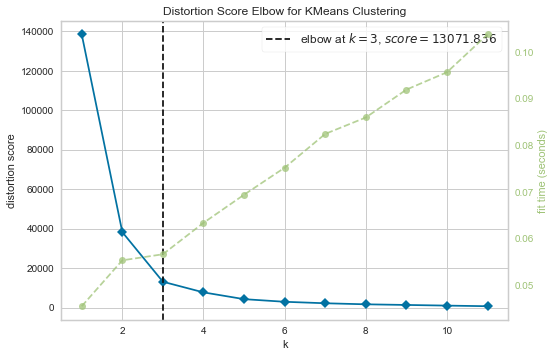

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [840]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,12)).fit(df)
visualizer.show()

In [841]:
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=0).fit(df)

In [842]:
kmeans.labels_ = np.where(kmeans.labels_ == 1, 3, kmeans.labels_)
kmeans.labels_ = np.where(kmeans.labels_ == 2, 1, kmeans.labels_)
kmeans.labels_ = np.where(kmeans.labels_ == 3, 2, kmeans.labels_)

In [843]:
Counter(kmeans.labels_)

Counter({2: 15, 0: 56, 1: 30})

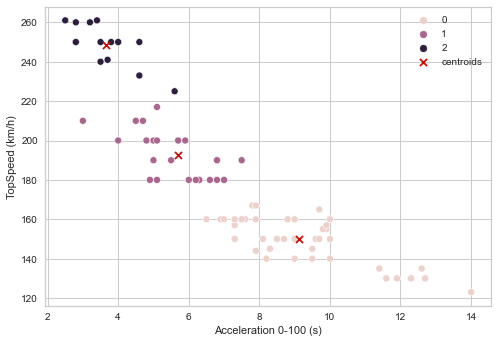

In [844]:
sns.scatterplot(data=df, x="Acceleration 0-100 (s)", y="TopSpeed (km/h)", hue=kmeans.labels_)
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], 
            marker="x", c="r", s=50, label="centroids")
plt.legend()
plt.show()

In [845]:
km_data.insert(4, 'Acceleration-TopSpeed category', value = kmeans.labels_)

### Range - FastCharge

In [846]:
# km_data = data

R_outliers = identify_outliers(km_data["Range (km)"])
km_data = km_data.drop(R_outliers.index)

FCH_outliers = identify_outliers(km_data["FastCharge (km/h)"])
km_data = km_data.drop(FCH_outliers.index)
km_data.drop(km_data.index[km_data['FastCharge (km/h)'] == 0], inplace=True)

In [847]:
df = pd.DataFrame(km_data, columns=["FastCharge (km/h)", "Range (km)"])

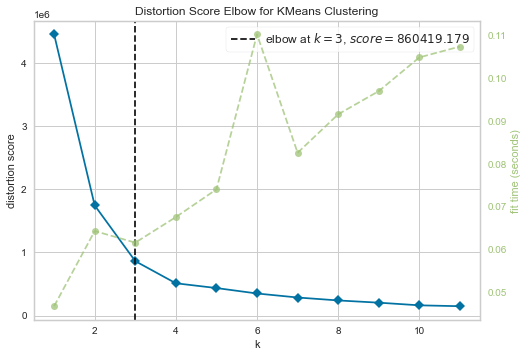

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [848]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,12)).fit(df)
visualizer.show()

In [849]:
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=0).fit(df)

In [850]:
kmeans.labels_ = np.where(kmeans.labels_ == 0, 3, kmeans.labels_)
kmeans.labels_ = np.where(kmeans.labels_ == 1, 0, kmeans.labels_)
kmeans.labels_ = np.where(kmeans.labels_ == 3, 1, kmeans.labels_)


In [851]:
Counter(kmeans.labels_)

Counter({2: 12, 0: 38, 1: 46})

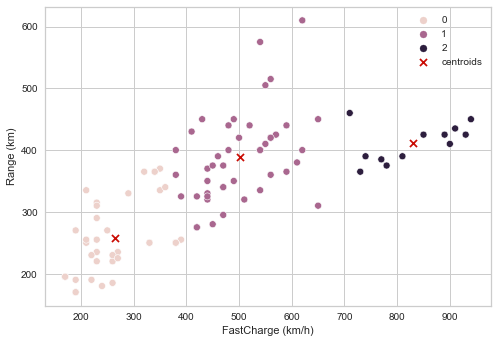

In [852]:
sns.scatterplot(data=df, x="FastCharge (km/h)", y="Range (km)", hue=kmeans.labels_)
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], 
            marker="x", c="r", s=50, label="centroids")
plt.legend()
plt.show()

In [853]:
km_data.insert(8, 'Range-FastCharge category', value = kmeans.labels_)

 # --------------------

Accuracy score on training set is 53.73134328358209
Accuracy score on test set is 55.172413793103445
[[16  0  0]
 [ 8  0  0]
 [ 5  0  0]]


<AxesSubplot:>

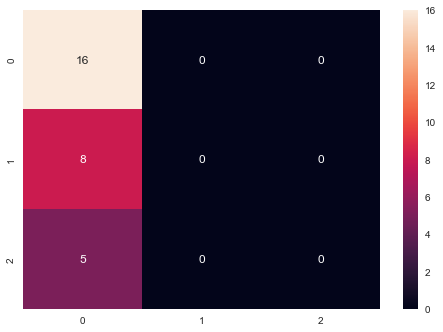

In [854]:
y1 = km_data[['Acceleration-TopSpeed category']]
x1 = km_data[['PriceEuro']]

# sns.regplot(x=x1, y=y1, data=km_data, ci=None)

X1_train, X1_test, y1_train, y1_test = train_test_split(x1, y1, test_size = 0.3, random_state = 3)

log = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=100)
log.fit(X1_train, y1_train.values.ravel())

pred1 = log.predict(X1_train)
pred2 = log.predict(X1_test)

score=accuracy_score(y1_train,pred1)
print("Accuracy score on training set is {}".format(score*100))

score=accuracy_score(y1_test,pred2)
print("Accuracy score on test set is {}".format(score*100))

# class_report=classification_report(y1_test, pred2)
# print(class_report)

cf_matrix = confusion_matrix(y1_test, pred2)
print(cf_matrix)

sns.heatmap(cf_matrix, annot=True)

Accuracy score on training set is 52.23880597014925
Accuracy score on test set is 37.93103448275862
[[ 0 14  0]
 [ 0 11  0]
 [ 0  4  0]]


<AxesSubplot:>

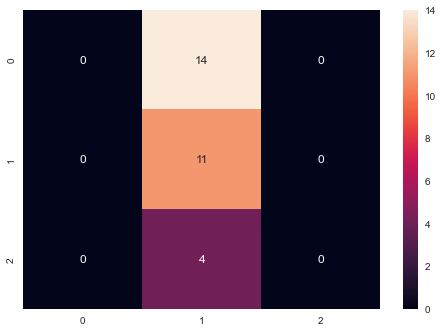

In [855]:
y1 = km_data[['Range-FastCharge category']]
x1 = km_data[['PriceEuro']]

# sns.regplot(x=x1, y=y1, data=km_data, ci=None)

X1_train, X1_test, y1_train, y1_test = train_test_split(x1, y1, test_size = 0.3, random_state = 5)

log = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=100)
log.fit(X1_train, y1_train.values.ravel())

pred1 = log.predict(X1_train)
pred2 = log.predict(X1_test)

score=accuracy_score(y1_train,pred1)
print("Accuracy score on training set is {}".format(score*100))

score=accuracy_score(y1_test,pred2)
print("Accuracy score on test set is {}".format(score*100))

# class_report=classification_report(y1_test, pred2)
# print(class_report)

cf_matrix = confusion_matrix(y1_test, pred2)
print(cf_matrix)

sns.heatmap(cf_matrix, annot=True)

In [856]:
x=km_data[['Acceleration-TopSpeed category','Range-FastCharge category']]
y=km_data['PriceEuro']
x= sm.add_constant(x)
results = sm.OLS(y,x)
model=results.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              PriceEuro   R-squared:                       0.548
Model:                            OLS   Adj. R-squared:                  0.538
Method:                 Least Squares   F-statistic:                     56.41
Date:                Tue, 29 Mar 2022   Prob (F-statistic):           9.07e-17
Time:                        12:58:13   Log-Likelihood:                -1088.9
No. Observations:                  96   AIC:                             2184.
Df Residuals:                      93   BIC:                             2192.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                           3.432e+04   3132.737     10.957      0.000    2.81e+04    4.05e+04
Acceleration-TopSpeed category  2.403e+04   4211.389      5.706      0.000    1.57e+04    3.24e+04
Range-FastCharge category       8784.2499   4666.272      1.882      0.063    -482.041    1.81e+04
==============================================================================
Omnibus:                       64.286   Durbin-Watson:                   2.048
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              382.197
Skew:                           2.087   Prob(JB):                     1.02e-83
Kurtosis:                      11.839   Cond. No.                         4.36
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

r-squared -> na zaklade 54.8% x hodnot viem vyjadrit y hodnotu (price) 

Väčšia (nevýznamná) p-hodnota naznačuje, že zmeny v prediktore nie sú spojené so zmenami v odpovedi.

Vo výstupe nižšie vidíme, že prediktorová premenná Acceleration-TopSpeed category je štatisticky významná, pretože p-hodnota je 0,000 (je menšia ako bežná hladina alfa 0,05).

### Hypotéza č. 3

#### Maximálna rýchlosť elektrických áut najviac závisí od ceny auta oproti ostatným atribútom.

In [857]:
x=data[['Acceleration 0-100 (s)','Range (km)', 'Efficiency (Wh/km)', 'FastCharge (km/h)', 'RapidCharge', 'PowerTrain', 'BodyStyle', 'Segment', 'Seats', 'PriceEuro']]
y=data['TopSpeed (km/h)']
x= sm.add_constant(x)
results = sm.OLS(y, x)
model=results.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        TopSpeed (km/h)   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     52.74
Date:                Tue, 29 Mar 2022   Prob (F-statistic):           9.83e-34
Time:                        12:58:13   Log-Likelihood:                -436.21
No. Observations:                 103   AIC:                             894.4
Df Residuals:                      92   BIC:                             923.4
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                    231.1784     31.081      7.438      0.000     169.448     292.909
Acceleration 0-100 (s)    -6.8038      1.287     -5.287      0.000      -9.360      -4.248
Range (km)                 0.0388      0.024      1.606      0.112      -0.009       0.087
Efficiency (Wh/km)        -0.1697      0.092     -1.847      0.068      -0.352       0.013
FastCharge (km/h)          0.0248      0.016      1.559      0.122      -0.007       0.056
RapidCharge              -37.6846     11.918     -3.162      0.002     -61.355     -14.014
PowerTrain                -1.1606      3.453     -0.336      0.738      -8.018       5.697
BodyStyle                 -0.1473      0.936     -0.157      0.875      -2.006       1.712
Segment                    4.4558      2.400      1.856      0.067      -0.312       9.223
Seats                      0.9430      3.306      0.285      0.776      -5.623       7.509
PriceEuro                  0.0004      0.000      4.111      0.000       0.000       0.001
==============================================================================
Omnibus:                       30.705   Durbin-Watson:                   2.220
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              344.902
Skew:                          -0.341   Prob(JB):                     1.28e-75
Kurtosis:                      11.939   Cond. No.                     1.18e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.18e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

R^2 score: 67.279


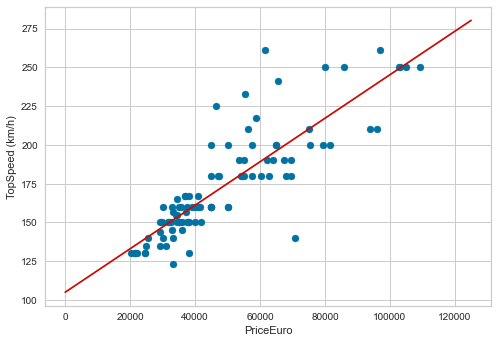

In [858]:
x = data[['PriceEuro']]
y = data['TopSpeed (km/h)']

ACC_outliers = identify_outliers(data["PriceEuro"])
x = x.drop(ACC_outliers.index)
y = y.drop(ACC_outliers.index)

TS_outliers = identify_outliers(data["TopSpeed (km/h)"])

try:
    x = x.drop(TS_outliers.index)
    y = y.drop(TS_outliers.index)
except:
    pass
    
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 50)

lr= LinearRegression()
lr.fit(X_train, y_train)
pred = lr.predict(X_test)

# r2=(r2_score(y_train,pred))
# print(r2*100)

print("R^2 score: %.3f" % ((r2_score(y_test, pred)) * 100))

mymodel = np.poly1d(np.polyfit(x.iloc[:, 0], y, 1))
myline = np.linspace(1, 125000)

plt.scatter(x, y)
plt.plot(myline, mymodel(myline), 'r')
plt.xlabel('PriceEuro')
plt.ylabel('TopSpeed (km/h)')
plt.show()

R^2 score: 81.330


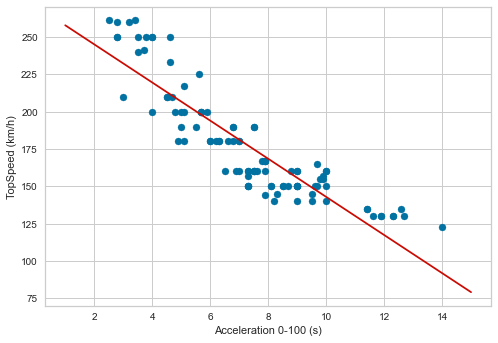

In [859]:
x=data[['Acceleration 0-100 (s)']]
y=data['TopSpeed (km/h)']

ACC_outliers = identify_outliers(data["Acceleration 0-100 (s)"])
x = x.drop(ACC_outliers.index)
y = y.drop(ACC_outliers.index)

TS_outliers = identify_outliers(data["TopSpeed (km/h)"])

try:
    x = x.drop(TS_outliers.index)
    y = y.drop(TS_outliers.index)
except:
    pass

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 50)

lr= LinearRegression()
lr.fit(X_train, y_train)
pred = lr.predict(X_test)

# r2=(r2_score(y_train,pred))
# print(r2*100)

r2=(r2_score(y_test,pred))
print("R^2 score: %.3f" % ((r2_score(y_test, pred)) * 100))

mymodel = np.poly1d(np.polyfit(x.iloc[:, 0], y, 1))

myline = np.linspace(1, 15)

plt.scatter(x, y)
plt.plot(myline, mymodel(myline), 'r')
plt.xlabel('Acceleration 0-100 (s)')
plt.ylabel('TopSpeed (km/h)')
plt.show()

Best degree 2 with RMSE 13.101125578163673


Text(0, 0.5, 'RMSE')

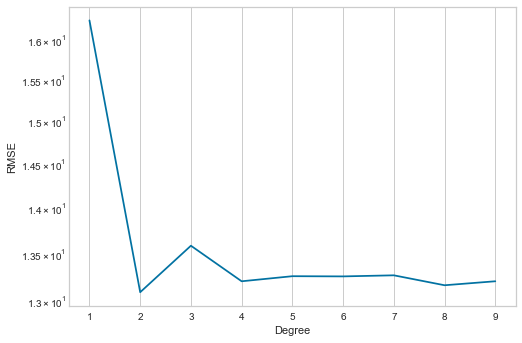

In [860]:
x=data[['Acceleration 0-100 (s)']]
y=data['TopSpeed (km/h)']

ACC_outliers = identify_outliers(data["Acceleration 0-100 (s)"])
x = x.drop(ACC_outliers.index)
y = y.drop(ACC_outliers.index)

TS_outliers = identify_outliers(data["TopSpeed (km/h)"])

try:
    x = x.drop(TS_outliers.index)
    y = y.drop(TS_outliers.index)
except:
    pass

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state = 50)

rmses = []
degrees = np.arange(1, 10)
min_rmse, min_deg = 1e10, 0

for deg in degrees:

    # Train features
    poly_features = PolynomialFeatures(degree=deg, include_bias=False)
    x_poly_train = poly_features.fit_transform(x_train)

    # Linear regression
    poly_reg = LinearRegression()
    poly_reg.fit(x_poly_train, y_train)

    # Compare with test data
    x_poly_test = poly_features.fit_transform(x_test)
    poly_predict = poly_reg.predict(x_poly_test)
    poly_mse = mean_squared_error(y_test, poly_predict)
    poly_rmse = np.sqrt(poly_mse)
    rmses.append(poly_rmse)
    
    # Cross-validation of degree
    if min_rmse > poly_rmse:
        min_rmse = poly_rmse
        min_deg = deg

# Plot and present results
print('Best degree {} with RMSE {}'.format(min_deg, min_rmse))
        
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(degrees, rmses)
ax.set_yscale('log')
ax.set_xlabel('Degree')
ax.set_ylabel('RMSE')

Best degree function

R^2 score: 81.330


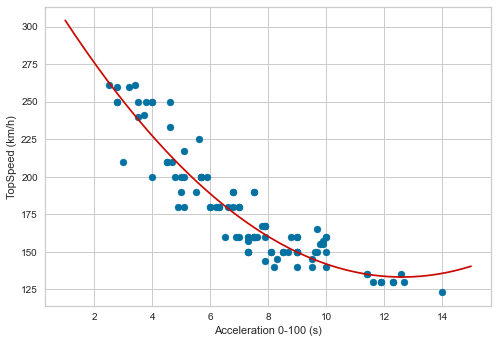

In [861]:
x=data[['Acceleration 0-100 (s)']]
y=data['TopSpeed (km/h)']

ACC_outliers = identify_outliers(data["Acceleration 0-100 (s)"])
x = x.drop(ACC_outliers.index)
y = y.drop(ACC_outliers.index)

TS_outliers = identify_outliers(data["TopSpeed (km/h)"])

try:
    x = x.drop(TS_outliers.index)
    y = y.drop(TS_outliers.index)
except:
    pass

poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(x)

X_train, X_test, y_train, y_test = train_test_split(poly_features, y, test_size=0.3, random_state = 50)

poly_reg_model = LinearRegression()
poly_reg_model.fit(X_train, y_train)

poly_reg_y_predicted = poly_reg_model.predict(X_test)
print("R^2 score: %.3f" % ((r2_score(y_test, pred)) * 100))

mymodel = np.poly1d(np.polyfit(x.iloc[:, 0], y, 2))

myline = np.linspace(1, 15)

plt.scatter(x, y)
plt.plot(myline, mymodel(myline), 'r')
plt.xlabel('Acceleration 0-100 (s)')
plt.ylabel('TopSpeed (km/h)')
plt.show()

R^2 score: 81.330


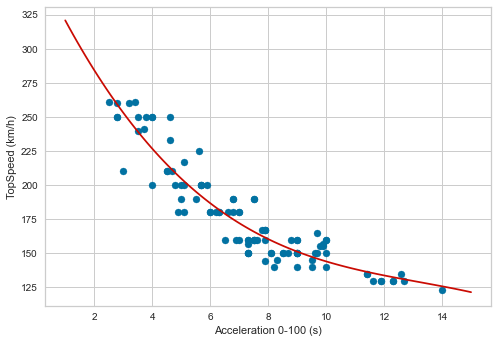

In [862]:
x=data[['Acceleration 0-100 (s)']]
y=data['TopSpeed (km/h)']

ACC_outliers = identify_outliers(data["Acceleration 0-100 (s)"])
x = x.drop(ACC_outliers.index)
y = y.drop(ACC_outliers.index)

TS_outliers = identify_outliers(data["TopSpeed (km/h)"])

try:
    x = x.drop(TS_outliers.index)
    y = y.drop(TS_outliers.index)
except:
    pass

poly = PolynomialFeatures(degree=3, include_bias=False)
poly_features = poly.fit_transform(x)

X_train, X_test, y_train, y_test = train_test_split(poly_features, y, test_size=0.3, random_state = 50)

poly_reg_model = LinearRegression()
poly_reg_model.fit(X_train, y_train)

poly_reg_y_predicted = poly_reg_model.predict(X_test)
print("R^2 score: %.3f" % ((r2_score(y_test, pred)) * 100))

mymodel = np.poly1d(np.polyfit(x.iloc[:, 0], y, 3))

myline = np.linspace(1, 15, 100)

plt.scatter(x, y)
plt.plot(myline, mymodel(myline), 'r')
plt.xlabel('Acceleration 0-100 (s)')
plt.ylabel('TopSpeed (km/h)')
plt.show()